Code to develop Drought Indicators for the Vulnerable Communities Platform Data source: https://cadcat.s3.amazonaws.com/index.html#loca2/aaa-ca-hybrid/ Code support via Gemini Data draws from 5 General Use Projections https://www.energy.ca.gov/sites/default/files/2024-10/07_General_Use_Projections_Data_Justification_Sept2024_ada.pdf and averaged for 2015-2044 and 2045-2074 to provide high level overviews of climate risk/vulnerability. 
Code/Analysis developed by Climate Serices at Govenor's Office of Land Use and Climate Innovation Ben McMahan (ben.mcmahan@lci.ca.gov)

In [2]:
import os

# Get the current working directory (optional)
current_directory = os.getcwd()
#print(f"Current directory: {current_directory}")

# Define the new directory path
new_directory = "I:/loca2/gen_use"  # Replace with your desired path

# Change the directory
try:
    os.chdir(new_directory)
    print(f"Successfully changed directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error: The directory '{new_directory}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully changed directory to: I:\loca2\gen_use


In [9]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_ACCESS.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_ACCESS.nc


In [11]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_ACCESS_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_ACCESS.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_ACCESS_OctMar.nc


In [15]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_ACCESS_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_ACCESS_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_1950-2014_ACCESS_OctMar_median.nc


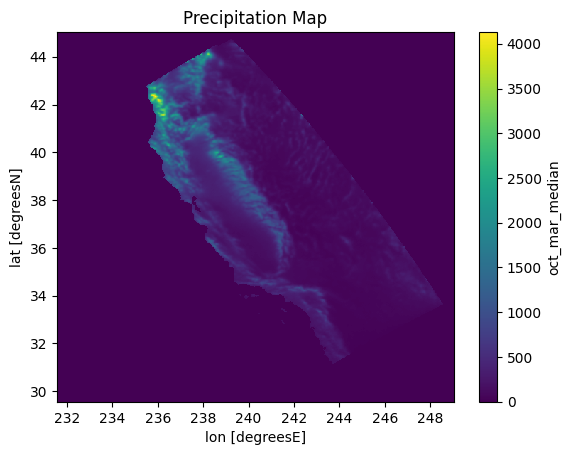

In [24]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot() #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_monthly_totals_1950-2014_ACCESS_OctMar_Median.nc"  # Replace with your NetCDF file path
variable_to_map = "oct_mar_median"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

In [26]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_ACCESS.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_ACCESS.nc


In [39]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_ACCESS_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_ACCESS.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_ACCESS_OctMar.nc


In [41]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_ACCESS_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_ACCESS_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2015-2044_ACCESS_OctMar_median.nc


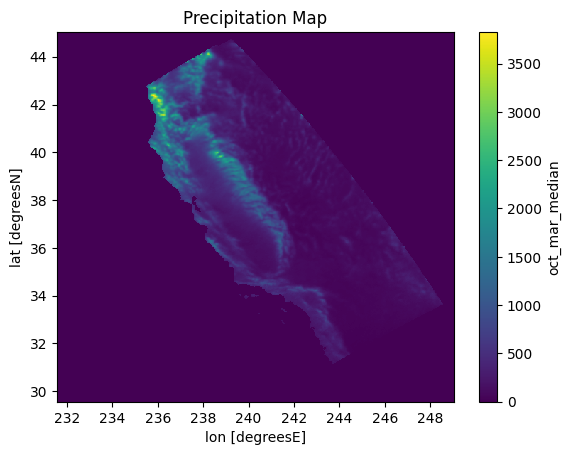

In [43]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot() #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_monthly_totals_2015-2044_ACCESS_OctMar_median.nc"  # Replace with your NetCDF file path
variable_to_map = "oct_mar_median"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

In [45]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_ACCESS.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_ACCESS.nc


In [46]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_ACCESS_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_ACCESS.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_ACCESS_OctMar.nc


In [49]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_ACCESS_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_ACCESS_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2045-2074_ACCESS_OctMar_median.nc


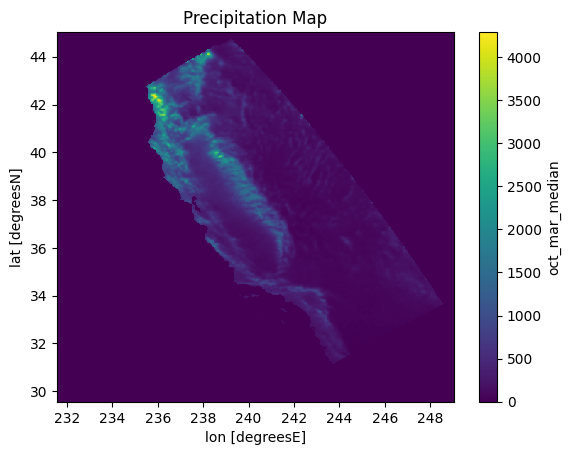

In [51]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot() #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_monthly_totals_2045-2074_ACCESS_OctMar_median.nc"  # Replace with your NetCDF file path
variable_to_map = "oct_mar_median"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

In [ ]:
# 'VCP_DROUGHT_monthly_totals_1950-2014_ACCESS_OctMar_median.nc'
# 'VCP_DROUGHT_monthly_totals_2015-2044_ACCESS_OctMar_median.nc'
# 'VCP_DROUGHT_monthly_totals_2045-2074_ACCESS_OctMar_median.nc'

In [53]:
def calculate_and_save_index(hist_expected_file, early_file, late_file, early_index_file, late_index_file):
    """
    Loads NetCDF files, calculates the index, and saves the result.

    Args:
        hist_expected_file (str): Path to hist_expected.nc.
        early_file (str): Path to early.nc.
        late_file (str): Path to late.nc.
        early_index_file (str): Path to save early_index.nc.
        late_index_file (str): Path to save late_index.nc.
    """
    try:
        hist_expected = xr.open_dataset(hist_expected_file)
        early = xr.open_dataset(early_file)
        late = xr.open_dataset(late_file)

        early_index = ((early['oct_mar_median']) / hist_expected['oct_mar_median'])# - early['pr']
        late_index = ((late['oct_mar_median']) / hist_expected['oct_mar_median'])# - late['pr']

        early_index_ds = xr.Dataset({'early_index': early_index})
        late_index_ds = xr.Dataset({'late_index': late_index})

        early_index_ds.to_netcdf(early_index_file)
        late_index_ds.to_netcdf(late_index_file)

        print(f"Calculated and saved: {early_index_file} and {late_index_file}")

    except FileNotFoundError:
        print("Error: One or more input files not found.")
    except Exception as e:
        print(f"Error calculating index: {e}")

# Calculate and save the index
calculate_and_save_index("VCP_DROUGHT_monthly_totals_1950-2014_ACCESS_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2015-2044_ACCESS_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2045-2074_ACCESS_OctMar_median.nc", 
                         "VCP_DROUGHT_02A-1_monthly_totals_2015-2044_ACCESS_OctMar_medianINDEX.nc", 
                         "VCP_DROUGHT_02B-1_monthly_totals_2045-2074_ACCESS_OctMar_medianINDEX.nc")

Calculated and saved: VCP_DROUGHT_02A-1_monthly_totals_2015-2044_ACCESS_OctMar_medianINDEX.nc and VCP_DROUGHT_02B-1_monthly_totals_2045-2074_ACCESS_OctMar_medianINDEX.nc


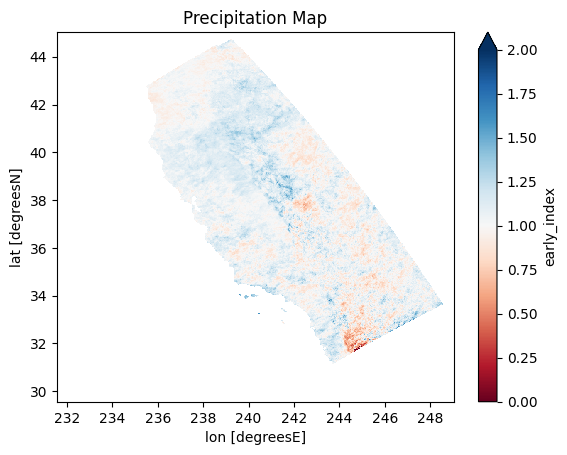

In [65]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02A-1_monthly_totals_2015-2044_ACCESS_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "early_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

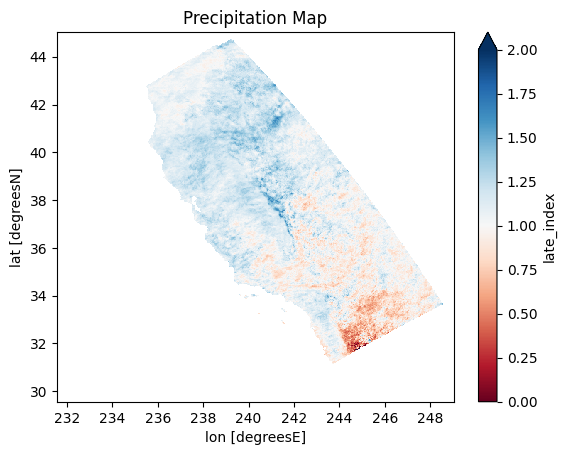

In [83]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02B-1_monthly_totals_2045-2074_ACCESS_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "late_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

In [86]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_Earth3.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.EC-Earth3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_Earth3.nc


In [87]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_Earth3_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_Earth3.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_Earth3_OctMar.nc


In [88]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_Earth3_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_Earth3_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_1950-2014_Earth3_OctMar_median.nc


In [89]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_Earth3.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.EC-Earth3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_Earth3.nc


In [90]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_Earth3_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_Earth3.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_Earth3_OctMar.nc


In [91]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_Earth3_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_Earth3_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2015-2044_Earth3_OctMar_median.nc


In [92]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_Earth3.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.EC-Earth3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_Earth3.nc


In [93]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_Earth3_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_Earth3.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_Earth3_OctMar.nc


In [94]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_Earth3_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_Earth3_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2045-2074_Earth3_OctMar_median.nc


In [95]:
def calculate_and_save_index(hist_expected_file, early_file, late_file, early_index_file, late_index_file):
    """
    Loads NetCDF files, calculates the index, and saves the result.

    Args:
        hist_expected_file (str): Path to hist_expected.nc.
        early_file (str): Path to early.nc.
        late_file (str): Path to late.nc.
        early_index_file (str): Path to save early_index.nc.
        late_index_file (str): Path to save late_index.nc.
    """
    try:
        hist_expected = xr.open_dataset(hist_expected_file)
        early = xr.open_dataset(early_file)
        late = xr.open_dataset(late_file)

        early_index = ((early['oct_mar_median']) / hist_expected['oct_mar_median'])# - early['pr']
        late_index = ((late['oct_mar_median']) / hist_expected['oct_mar_median'])# - late['pr']

        early_index_ds = xr.Dataset({'early_index': early_index})
        late_index_ds = xr.Dataset({'late_index': late_index})

        early_index_ds.to_netcdf(early_index_file)
        late_index_ds.to_netcdf(late_index_file)

        print(f"Calculated and saved: {early_index_file} and {late_index_file}")

    except FileNotFoundError:
        print("Error: One or more input files not found.")
    except Exception as e:
        print(f"Error calculating index: {e}")

# Calculate and save the index
calculate_and_save_index("VCP_DROUGHT_monthly_totals_1950-2014_Earth3_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2015-2044_Earth3_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2045-2074_Earth3_OctMar_median.nc", 
                         "VCP_DROUGHT_02A-2_monthly_totals_2015-2044_Earth3_OctMar_medianINDEX.nc", 
                         "VCP_DROUGHT_02B-2_monthly_totals_2045-2074_Earth3_OctMar_medianINDEX.nc")

Calculated and saved: VCP_DROUGHT_02A-2_monthly_totals_2015-2044_Earth3_OctMar_medianINDEX.nc and VCP_DROUGHT_02B-2_monthly_totals_2045-2074_Earth3_OctMar_medianINDEX.nc


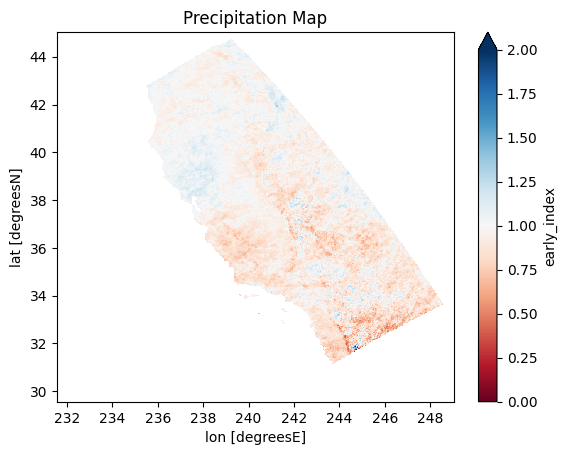

In [96]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02A-2_monthly_totals_2015-2044_Earth3_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "early_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

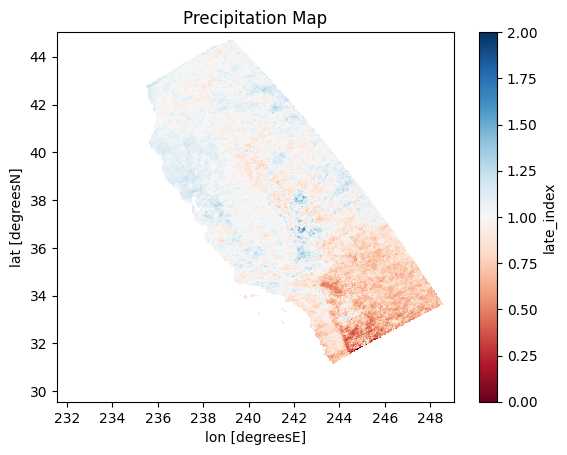

In [123]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02B-2_monthly_totals_2045-2074_Earth3_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "late_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

In [125]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_FGOALS.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.FGOALS-g3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_FGOALS.nc


In [126]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_FGOALS_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_FGOALS.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_FGOALS_OctMar.nc


In [127]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_FGOALS_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_FGOALS_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_1950-2014_FGOALS_OctMar_median.nc


In [128]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_FGOALS.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.FGOALS-g3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_FGOALS.nc


In [129]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_FGOALS_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_FGOALS.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_FGOALS_OctMar.nc


In [130]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_FGOALS_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_FGOALS_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2015-2044_FGOALS_OctMar_median.nc


In [131]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_FGOALS.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.FGOALS-g3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_FGOALS.nc


In [132]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_FGOALS_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_FGOALS.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_FGOALS_OctMar.nc


In [133]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_FGOALS_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_FGOALS_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2045-2074_FGOALS_OctMar_median.nc


In [134]:
def calculate_and_save_index(hist_expected_file, early_file, late_file, early_index_file, late_index_file):
    """
    Loads NetCDF files, calculates the index, and saves the result.

    Args:
        hist_expected_file (str): Path to hist_expected.nc.
        early_file (str): Path to early.nc.
        late_file (str): Path to late.nc.
        early_index_file (str): Path to save early_index.nc.
        late_index_file (str): Path to save late_index.nc.
    """
    try:
        hist_expected = xr.open_dataset(hist_expected_file)
        early = xr.open_dataset(early_file)
        late = xr.open_dataset(late_file)

        early_index = ((early['oct_mar_median']) / hist_expected['oct_mar_median'])# - early['pr']
        late_index = ((late['oct_mar_median']) / hist_expected['oct_mar_median'])# - late['pr']

        early_index_ds = xr.Dataset({'early_index': early_index})
        late_index_ds = xr.Dataset({'late_index': late_index})

        early_index_ds.to_netcdf(early_index_file)
        late_index_ds.to_netcdf(late_index_file)

        print(f"Calculated and saved: {early_index_file} and {late_index_file}")

    except FileNotFoundError:
        print("Error: One or more input files not found.")
    except Exception as e:
        print(f"Error calculating index: {e}")

# Calculate and save the index
calculate_and_save_index("VCP_DROUGHT_monthly_totals_1950-2014_FGOALS_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2015-2044_FGOALS_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2045-2074_FGOALS_OctMar_median.nc", 
                         "VCP_DROUGHT_02A-3_monthly_totals_2015-2044_FGOALS_OctMar_medianINDEX.nc", 
                         "VCP_DROUGHT_02B-3_monthly_totals_2045-2074_FGOALS_OctMar_medianINDEX.nc")

Calculated and saved: VCP_DROUGHT_02A-3_monthly_totals_2015-2044_FGOALS_OctMar_medianINDEX.nc and VCP_DROUGHT_02B-3_monthly_totals_2045-2074_FGOALS_OctMar_medianINDEX.nc


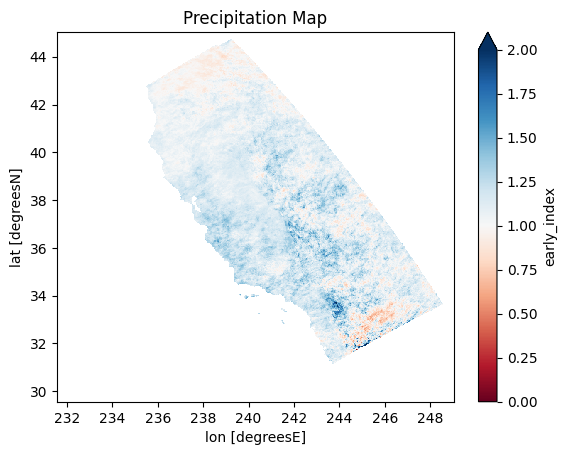

In [135]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02A-3_monthly_totals_2015-2044_FGOALS_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "early_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

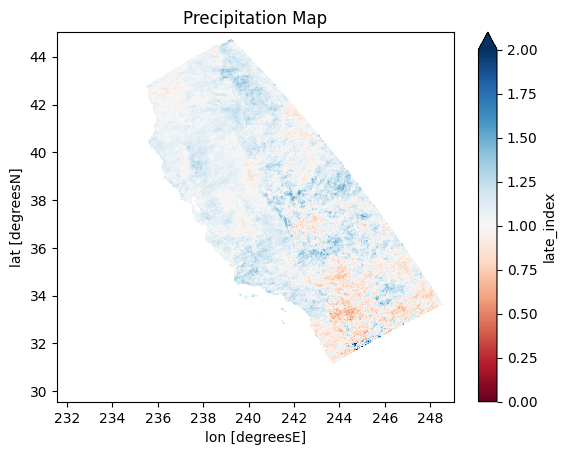

In [136]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02B-3_monthly_totals_2045-2074_FGOALS_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "late_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

In [168]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_MIROC.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.MIROC6.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_MIROC.nc


In [169]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_MIROC_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_MIROC.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_MIROC_OctMar.nc


In [170]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_MIROC_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_MIROC_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_1950-2014_MIROC_OctMar_median.nc


In [171]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_MIROC.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.MIROC6.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_MIROC.nc


In [172]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_MIROC_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_MIROC.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_MIROC_OctMar.nc


In [173]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_MIROC_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_MIROC_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2015-2044_MIROC_OctMar_median.nc


In [174]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_MIROC.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.MIROC6.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_MIROC.nc


In [175]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_MIROC_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_MIROC.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_MIROC_OctMar.nc


In [176]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_MIROC_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_MIROC_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2045-2074_MIROC_OctMar_median.nc


In [177]:
def calculate_and_save_index(hist_expected_file, early_file, late_file, early_index_file, late_index_file):
    """
    Loads NetCDF files, calculates the index, and saves the result.

    Args:
        hist_expected_file (str): Path to hist_expected.nc.
        early_file (str): Path to early.nc.
        late_file (str): Path to late.nc.
        early_index_file (str): Path to save early_index.nc.
        late_index_file (str): Path to save late_index.nc.
    """
    try:
        hist_expected = xr.open_dataset(hist_expected_file)
        early = xr.open_dataset(early_file)
        late = xr.open_dataset(late_file)

        early_index = ((early['oct_mar_median']) / hist_expected['oct_mar_median'])# - early['pr']
        late_index = ((late['oct_mar_median']) / hist_expected['oct_mar_median'])# - late['pr']

        early_index_ds = xr.Dataset({'early_index': early_index})
        late_index_ds = xr.Dataset({'late_index': late_index})

        early_index_ds.to_netcdf(early_index_file)
        late_index_ds.to_netcdf(late_index_file)

        print(f"Calculated and saved: {early_index_file} and {late_index_file}")

    except FileNotFoundError:
        print("Error: One or more input files not found.")
    except Exception as e:
        print(f"Error calculating index: {e}")

# Calculate and save the index
calculate_and_save_index("VCP_DROUGHT_monthly_totals_1950-2014_MIROC_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2015-2044_MIROC_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2045-2074_MIROC_OctMar_median.nc", 
                         "VCP_DROUGHT_02A-4_monthly_totals_2015-2044_MIROC_OctMar_medianINDEX.nc", 
                         "VCP_DROUGHT_02B-4_monthly_totals_2045-2074_MIROC_OctMar_medianINDEX.nc")

Calculated and saved: VCP_DROUGHT_02A-4_monthly_totals_2015-2044_MIROC_OctMar_medianINDEX.nc and VCP_DROUGHT_02B-4_monthly_totals_2045-2074_MIROC_OctMar_medianINDEX.nc


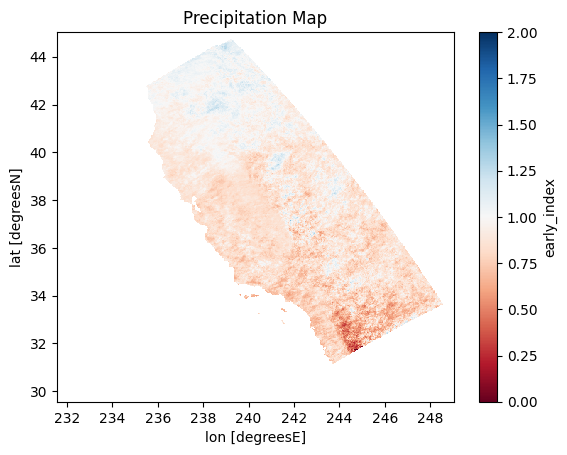

In [178]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02A-4_monthly_totals_2015-2044_MIROC_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "early_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

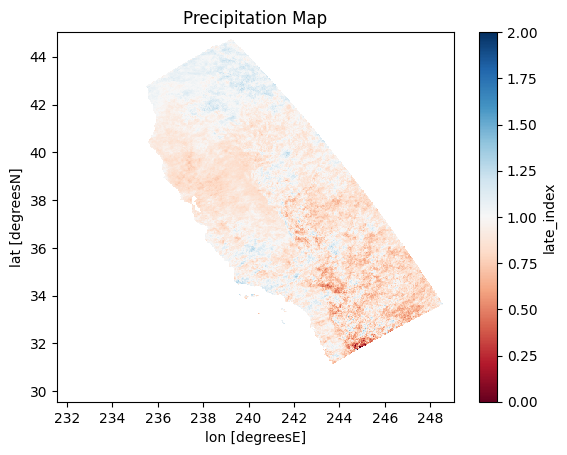

In [179]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02B-4_monthly_totals_2045-2074_MIROC_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "late_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

In [207]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_MPI.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.MPI-ESM1-2-HR.historical.r3i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_MPI.nc


In [208]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_MPI_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_MPI.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_1950-2014_MPI_OctMar.nc


In [209]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_1950-2014_MPI_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_1950-2014_MPI_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_1950-2014_MPI_OctMar_median.nc


In [210]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_MPI.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_MPI.nc


In [211]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_MPI_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_MPI.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2015-2044_MPI_OctMar.nc


In [212]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2015-2044_MPI_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2015-2044_MPI_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2015-2044_MPI_OctMar_median.nc


In [213]:
import xarray as xr
import dask

def calculate_monthly_totals(ds, pr_var='pr', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_MPI.nc'):
    """
    Calculates monthly totals for a given variable at each lat/lon location and saves to a NetCDF file, using Dask.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the precipitation variable.
        time_var (str): The name of the time variable (must be datetime64[ns]).
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    ds[pr_var] = ds[pr_var] * 86400

    # Ensure Dask is used for resample and sum operations
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        monthly_totals = ds[pr_var].resample({time_var: "MS"}).sum(keep_attrs=True)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'monthly_total': monthly_totals
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"Monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('pr.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc', chunks={'time': 'auto'})  # Load with Dask chunks
calculate_monthly_totals(ds)

Monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_MPI.nc


In [214]:
import pandas as pd 
def calculate_oct_mar_monthly_totals(ds, pr_var='monthly_total', time_var='time', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_MPI_OctMar.nc'):
    if ds[time_var].dtype != 'datetime64[ns]':
        raise ValueError(f"The '{time_var}' variable must be of datetime64[ns] dtype.")

    years = pd.Series(ds[time_var].values).dt.year.unique()  # Explicit conversion to pandas Series

    oct_mar_totals = []

    for year in years[:-1]:
        oct_dec = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year) & (ds[time_var].dt.month.isin([10, 11, 12]))}).sum(dim=time_var)
        jan_mar = ds[pr_var].sel({time_var: (ds[time_var].dt.year == year + 1) & (ds[time_var].dt.month.isin([1, 2, 3]))}).sum(dim=time_var)
        oct_mar_total = oct_dec + jan_mar
        oct_mar_total = oct_mar_total.assign_coords({'year': year})
        oct_mar_totals.append(oct_mar_total)

    oct_mar_totals_da = xr.concat(oct_mar_totals, dim='year')

    output_ds = xr.Dataset({
        'oct_mar_total': oct_mar_totals_da
    })

    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    output_ds.to_netcdf(output_filename)
    print(f"October-March monthly totals written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_MPI.nc')
calculate_oct_mar_monthly_totals(ds)

October-March monthly totals written to VCP_DROUGHT_monthly_totals_2045-2074_MPI_OctMar.nc


In [215]:
def calculate_oct_mar_median(ds, pr_var='oct_mar_total', year_var='year', lat_var='lat', lon_var='lon', output_filename='VCP_DROUGHT_monthly_totals_2045-2074_MPI_OctMar_median.nc'):
    """
    Calculates the median October-March total for each lat/lon location and saves to a NetCDF file.

    Args:
        ds (xarray.Dataset): The input xarray Dataset.
        pr_var (str): The name of the October-March total variable.
        year_var (str): The name of the year variable.
        lat_var (str): The name of the latitude variable.
        lon_var (str): The name of the longitude variable.
        output_filename (str): The name of the output NetCDF file.
    """

    if year_var not in ds.coords:
        raise ValueError(f"The '{year_var}' coordinate must exist in the dataset.")

    oct_mar_median = ds[pr_var].median(dim=year_var)

    # Create a new Dataset for the output
    output_ds = xr.Dataset({
        'oct_mar_median': oct_mar_median
    })

    # Add latitude and longitude coordinates if they exist in the input dataset
    if lat_var in ds.coords:
        output_ds = output_ds.assign_coords({lat_var: ds[lat_var]})
    if lon_var in ds.coords:
        output_ds = output_ds.assign_coords({lon_var: ds[lon_var]})

    # Write the Dataset to a NetCDF file
    output_ds.to_netcdf(output_filename)
    print(f"October-March median written to {output_filename}")

# Example Usage:
ds = xr.open_dataset('VCP_DROUGHT_monthly_totals_2045-2074_MPI_OctMar.nc')  # Replace with your filename
calculate_oct_mar_median(ds)


October-March median written to VCP_DROUGHT_monthly_totals_2045-2074_MPI_OctMar_median.nc


In [216]:
def calculate_and_save_index(hist_expected_file, early_file, late_file, early_index_file, late_index_file):
    """
    Loads NetCDF files, calculates the index, and saves the result.

    Args:
        hist_expected_file (str): Path to hist_expected.nc.
        early_file (str): Path to early.nc.
        late_file (str): Path to late.nc.
        early_index_file (str): Path to save early_index.nc.
        late_index_file (str): Path to save late_index.nc.
    """
    try:
        hist_expected = xr.open_dataset(hist_expected_file)
        early = xr.open_dataset(early_file)
        late = xr.open_dataset(late_file)

        early_index = ((early['oct_mar_median']) / hist_expected['oct_mar_median'])# - early['pr']
        late_index = ((late['oct_mar_median']) / hist_expected['oct_mar_median'])# - late['pr']

        early_index_ds = xr.Dataset({'early_index': early_index})
        late_index_ds = xr.Dataset({'late_index': late_index})

        early_index_ds.to_netcdf(early_index_file)
        late_index_ds.to_netcdf(late_index_file)

        print(f"Calculated and saved: {early_index_file} and {late_index_file}")

    except FileNotFoundError:
        print("Error: One or more input files not found.")
    except Exception as e:
        print(f"Error calculating index: {e}")

# Calculate and save the index
calculate_and_save_index("VCP_DROUGHT_monthly_totals_1950-2014_MPI_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2015-2044_MPI_OctMar_median.nc", 
                         "VCP_DROUGHT_monthly_totals_2045-2074_MPI_OctMar_median.nc", 
                         "VCP_DROUGHT_02A-5_monthly_totals_2015-2044_MPI_OctMar_medianINDEX.nc", 
                         "VCP_DROUGHT_02B-5_monthly_totals_2045-2074_MPI_OctMar_medianINDEX.nc")

Calculated and saved: VCP_DROUGHT_02A-5_monthly_totals_2015-2044_MPI_OctMar_medianINDEX.nc and VCP_DROUGHT_02B-5_monthly_totals_2045-2074_MPI_OctMar_medianINDEX.nc


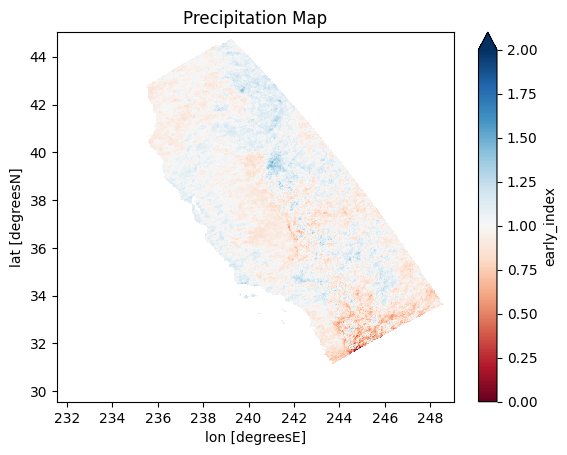

In [217]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02A-5_monthly_totals_2015-2044_MPI_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "early_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

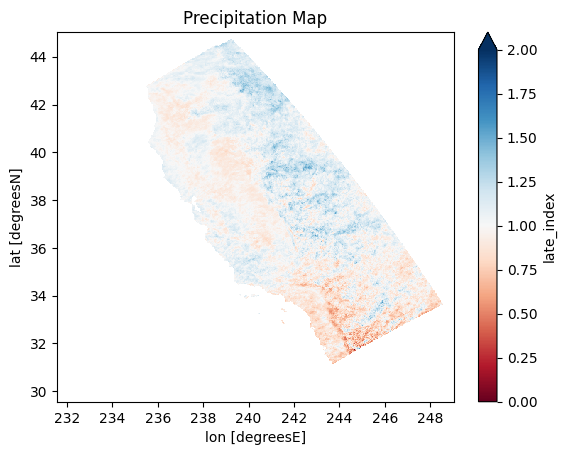

In [218]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02B-5_monthly_totals_2045-2074_MPI_OctMar_medianINDEX.nc"  # Replace with your NetCDF file path
variable_to_map = "late_index"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

In [241]:
import xarray as xr
import glob # For finding files, or you can list them manually
import os

# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_DROUGHT_02A-*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "early_index"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_DROUGHT_02A_OctMar_PctMedian_GENUSE-AVE_2015-2044.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found files: ['VCP_DROUGHT_02A-1_monthly_totals_2015-2044_ACCESS_OctMar_medianINDEX.nc', 'VCP_DROUGHT_02A-2_monthly_totals_2015-2044_Earth3_OctMar_medianINDEX.nc', 'VCP_DROUGHT_02A-3_monthly_totals_2015-2044_FGOALS_OctMar_medianINDEX.nc', 'VCP_DROUGHT_02A-4_monthly_totals_2015-2044_MIROC_OctMar_medianINDEX.nc', 'VCP_DROUGHT_02A-5_monthly_totals_2015-2044_MPI_OctMar_medianINDEX.nc']

Combined dataset structure:
<xarray.Dataset> Size: 11MB
Dimensions:      (file_index: 5, lat: 495, lon: 559)
Coordinates:
  * lat          (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon          (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Dimensions without coordinates: file_index
Data variables:
    early_index  (file_index, lat, lon) float64 11MB nan nan nan ... nan nan nan

Calculated average along dimension: 'file_index'

Averaged data array structure:
<xarray.DataArray 'early_index' (lat: 495, lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],


In [243]:
import xarray as xr
import glob # For finding files, or you can list them manually
import os

# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_DROUGHT_02B-*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "late_index"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_DROUGHT_02B_OctMar_PctMedian_GENUSE-AVE_2045-2074.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found files: ['VCP_DROUGHT_02B-1_monthly_totals_2045-2074_ACCESS_OctMar_medianINDEX.nc', 'VCP_DROUGHT_02B-2_monthly_totals_2045-2074_Earth3_OctMar_medianINDEX.nc', 'VCP_DROUGHT_02B-3_monthly_totals_2045-2074_FGOALS_OctMar_medianINDEX.nc', 'VCP_DROUGHT_02B-4_monthly_totals_2045-2074_MIROC_OctMar_medianINDEX.nc', 'VCP_DROUGHT_02B-5_monthly_totals_2045-2074_MPI_OctMar_medianINDEX.nc']

Combined dataset structure:
<xarray.Dataset> Size: 11MB
Dimensions:     (file_index: 5, lat: 495, lon: 559)
Coordinates:
  * lat         (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon         (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Dimensions without coordinates: file_index
Data variables:
    late_index  (file_index, lat, lon) float64 11MB nan nan nan ... nan nan nan

Calculated average along dimension: 'file_index'

Averaged data array structure:
<xarray.DataArray 'late_index' (lat: 495, lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
     

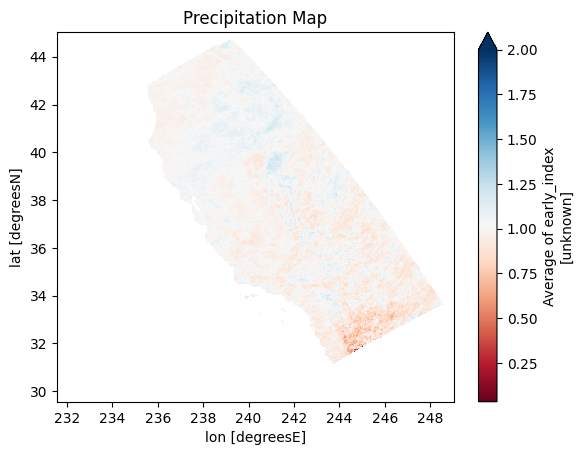

In [249]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02A_OctMar_PctMedian_GENUSE-AVE_2015-2044.nc"  # Replace with your NetCDF file path
variable_to_map = "early_index_mean"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)

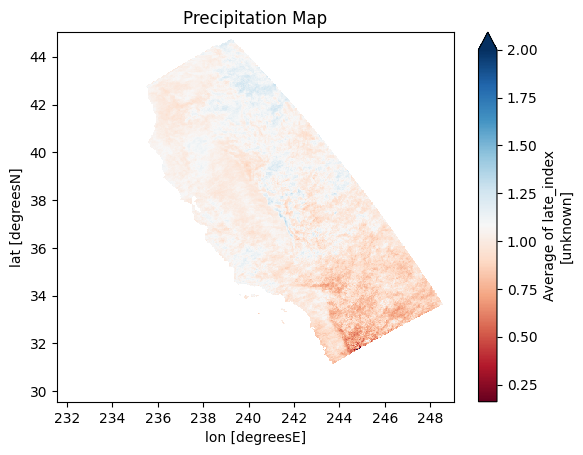

In [251]:
import xarray as xr
import matplotlib.pyplot as plt

def load_and_map_netcdf(file_path, variable_name='pr', title='Mapped Data'):
    """
    Loads a NetCDF file, maps a specified variable, and displays the plot.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to map (default: 'pr').
        title (str): Title for the plot.
    """
    try:
        ds = xr.open_dataset(file_path)
        if variable_name not in ds:
            print(f"Error: Variable '{variable_name}' not found in the NetCDF file.")
            return

        data_to_plot = ds[variable_name]

        # Check for latitude and longitude dimensions
        if 'lat' in data_to_plot.dims and 'lon' in data_to_plot.dims:
            data_to_plot.plot(vmax=2,cmap='RdBu') #xarray handles the mapping automatically.
            plt.title(title)
            plt.show()
        else:
            print("Error: The variable does not have 'lat' and 'lon' dimensions, so mapping is not possible.")

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example usage:
file_path = "VCP_DROUGHT_02B_OctMar_PctMedian_GENUSE-AVE_2045-2074.nc"  # Replace with your NetCDF file path
variable_to_map = "late_index_mean"  # Replace with the variable you want to map
plot_title = "Precipitation Map"

load_and_map_netcdf(file_path, variable_to_map, plot_title)